In [18]:
#Load packages
import pandas as pd
import numpy as np
import scipy.io as sio
import random
import scipy
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

In [19]:
#This function is used to encode labels since labels are categorical.
def encode_labels(labels):
    le = LabelEncoder()
    le.fit(labels)
    encoded_labels = le.transform(labels)
    
    return encoded_labels, le

def decode_labels(encoded_predict_labels, le):
    test_predictions = le.inverse_transform(encoded_predict_labels)
    
    return test_predictions

#Load data
train = sio.loadmat('train.mat')
validation = sio.loadmat('validation.mat')
test = sio.loadmat('test_wolabels.mat')

train_classid = np.squeeze(train['classid'])
train_class_labels = []
for item in train_classid:
    train_class_labels.append(item[0])
train_features = train['features']
train_imid = train['imid']
train_sampleid = train['sampleid']
print(train_features.shape)
train_unique_labels = sorted(np.unique(train_class_labels))
train_unique_labels_count = len(train_unique_labels)
print(train_unique_labels_count)

validation_classid = np.squeeze(validation['classid'])
validation_class_labels = []
for item in validation_classid:
    validation_class_labels.append(item[0])
validation_features = validation['features']
validation_imid = validation['imid']
validation_sampleid = validation['sampleid']
print(validation_features.shape)
validation_unique_labels = sorted(np.unique(validation_class_labels))
validation_unique_labels_count = len(validation_unique_labels)
print(validation_unique_labels_count)

#encoded train labels
train_labels, le = encode_labels(train_class_labels)
print(len(train_labels))

#encoded validation labels
validation_labels = le.transform(validation_class_labels)
print(len(validation_labels))

(7849, 2048)
1013
(1379, 2048)
1013
7849
1379


In [20]:
Count = Counter(train_labels)
print(Count)

Counter({526: 60, 344: 57, 677: 45, 517: 42, 715: 41, 92: 40, 283: 38, 584: 36, 890: 36, 712: 35, 95: 32, 535: 31, 183: 30, 343: 30, 441: 30, 606: 30, 634: 30, 80: 29, 99: 29, 556: 29, 532: 28, 85: 27, 992: 27, 489: 26, 639: 26, 684: 26, 41: 25, 692: 25, 898: 25, 215: 24, 288: 24, 421: 24, 720: 24, 91: 23, 104: 23, 349: 23, 409: 23, 669: 23, 48: 22, 190: 22, 348: 22, 470: 22, 529: 22, 907: 22, 984: 22, 93: 21, 258: 21, 326: 21, 430: 21, 534: 21, 24: 20, 198: 20, 265: 20, 378: 20, 388: 20, 511: 20, 522: 20, 96: 19, 102: 19, 120: 19, 331: 19, 351: 19, 389: 19, 420: 19, 664: 19, 926: 19, 39: 18, 137: 18, 157: 18, 304: 18, 347: 18, 374: 18, 461: 18, 468: 18, 519: 18, 543: 18, 559: 18, 582: 18, 775: 18, 828: 18, 920: 18, 121: 17, 148: 17, 346: 17, 376: 17, 435: 17, 467: 17, 483: 17, 537: 17, 863: 17, 86: 16, 89: 16, 225: 16, 273: 16, 296: 16, 354: 16, 397: 16, 440: 16, 460: 16, 727: 16, 732: 16, 745: 16, 876: 16, 883: 16, 888: 16, 892: 16, 158: 15, 168: 15, 221: 15, 236: 15, 249: 15, 291: 1

In [21]:
index = np.where(train_labels == 784)[0][0]
print(index)
print(train_labels[index])

n, d = train_features.shape
print(n,d)

train_features_sm = np.zeros((n+1, d))
train_features_sm[:n,:] = train_features
train_features_sm[n,:] = train_features[index]
train_labels_sm = np.array(list(train_labels) + [train_labels[index]])

print(train_features_sm.shape)
print(len(train_labels_sm))
print(Counter(train_labels_sm))

6322
784
7849 2048
(7850, 2048)
7850
Counter({526: 60, 344: 57, 677: 45, 517: 42, 715: 41, 92: 40, 283: 38, 584: 36, 890: 36, 712: 35, 95: 32, 535: 31, 183: 30, 343: 30, 441: 30, 606: 30, 634: 30, 80: 29, 99: 29, 556: 29, 532: 28, 85: 27, 992: 27, 489: 26, 639: 26, 684: 26, 41: 25, 692: 25, 898: 25, 215: 24, 288: 24, 421: 24, 720: 24, 91: 23, 104: 23, 349: 23, 409: 23, 669: 23, 48: 22, 190: 22, 348: 22, 470: 22, 529: 22, 907: 22, 984: 22, 93: 21, 258: 21, 326: 21, 430: 21, 534: 21, 24: 20, 198: 20, 265: 20, 378: 20, 388: 20, 511: 20, 522: 20, 96: 19, 102: 19, 120: 19, 331: 19, 351: 19, 389: 19, 420: 19, 664: 19, 926: 19, 39: 18, 137: 18, 157: 18, 304: 18, 347: 18, 374: 18, 461: 18, 468: 18, 519: 18, 543: 18, 559: 18, 582: 18, 775: 18, 828: 18, 920: 18, 121: 17, 148: 17, 346: 17, 376: 17, 435: 17, 467: 17, 483: 17, 537: 17, 863: 17, 86: 16, 89: 16, 225: 16, 273: 16, 296: 16, 354: 16, 397: 16, 440: 16, 460: 16, 727: 16, 732: 16, 745: 16, 876: 16, 883: 16, 888: 16, 892: 16, 158: 15, 168: 

In [22]:
#0-1 normalization
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
train_features_norm_sm = scalar.fit_transform(train_features_sm)
validation_features_norm = scalar.transform(validation_features)

In [23]:
#Using SMOTE for class imbalance
sm = BorderlineSMOTE(sampling_strategy = 'minority', k_neighbors=1, random_state=42)
for i in range(60):
    train_features_norm_sm, train_labels_sm = sm.fit_resample(train_features_norm_sm, train_labels_sm)

(7850, 2048)
(7850,)


<AxesSubplot:>

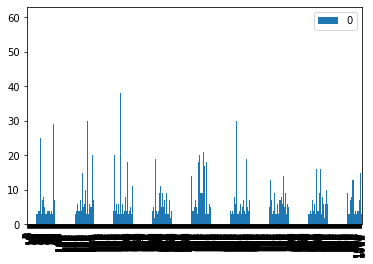

In [24]:
#After SMOTE
print(train_features_norm_sm.shape)
print(train_labels_sm.shape)

count = Counter(train_labels_sm)
df = pd.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

In [ ]:
pca = PCA(n_components=500)
train_features_red_sm = pca.fit_transform(train_features_norm_sm)
validation_features_red = pca.transform(validation_features_norm)
clf = LogisticRegression(C= 100, class_weight = 'balanced', random_state=0).fit(train_features_red_sm, train_labels_sm)
predictions = np.array(clf.predict(validation_features_red))
#calculate mean class accuracy
acc = accuracy_score(validation_labels, predictions)
print("Cost parameter: ", 100)
print("Mean class accuracy: ", acc)

Oversampling

In [6]:
#Using SMOTE for class imbalance
sm = SMOTE(sampling_strategy = 'minority', k_neighbors=1, random_state=42)
for i in range(200):
    train_features_norm_sm, train_labels_sm = sm.fit_resample(train_features_norm_sm, train_labels_sm)

(19272, 2048)
(19272,)


<AxesSubplot:>

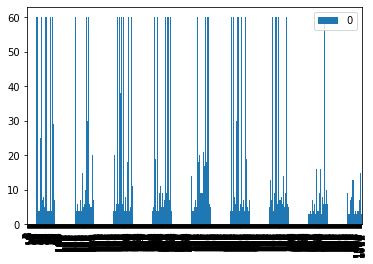

In [7]:
#After SMOTE
print(train_features_norm_sm.shape)
print(train_labels_sm.shape)

count = Counter(train_labels_sm)
df = pd.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

Logistic Regression with SMOTE (minority)

In [9]:
pca = PCA(n_components=500)
train_features_red_sm = pca.fit_transform(train_features_norm_sm)
validation_features_red = pca.transform(validation_features_norm)
clf = LogisticRegression(C= 100, class_weight = 'balanced', random_state=0).fit(train_features_red_sm, train_labels_sm)
predictions = np.array(clf.predict(validation_features_red))
#calculate mean class accuracy
acc = accuracy_score(validation_labels, predictions)
print("Cost parameter: ", 100)
print("Mean class accuracy: ", acc)

Cost parameter:  100
Mean class accuracy:  0.7628716461203771


/home/ntalukde/anaconda3/envs/NephNet3D/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [10]:
#Using SMOTE for class imbalance
sm = SMOTE(sampling_strategy = 'auto', k_neighbors=1, random_state=42)
train_features_norm_sm, train_labels_sm = sm.fit_resample(train_features_norm_sm, train_labels_sm)

(60780, 2048)
(60780,)


<AxesSubplot:>

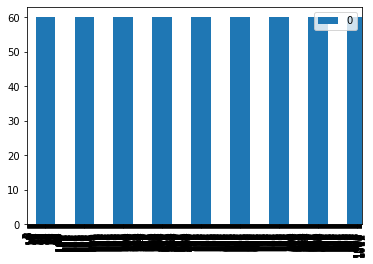

In [11]:
#After SMOTE
print(train_features_norm_sm.shape)
print(train_labels_sm.shape)

count = Counter(train_labels_sm)
df = pd.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

Logistic Regression with SMOTE (auto)

In [12]:
pca = PCA(n_components=500)
train_features_red_sm = pca.fit_transform(train_features_norm_sm)
validation_features_red = pca.transform(validation_features_norm)
clf = LogisticRegression( C = 100, class_weight = 'balanced', random_state = 0 ).fit(train_features_red_sm, train_labels_sm)
predictions = np.array(clf.predict(validation_features_red))
#calculate mean class accuracy
acc = accuracy_score(validation_labels, predictions)
print("Cost parameter: ", 100)
print("Mean class accuracy: ", acc)

Cost parameter:  100
Mean class accuracy:  0.7585206671501088


/home/ntalukde/anaconda3/envs/NephNet3D/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [15]:
#Using SMOTE for class imbalance
sm = BorderlineSMOTE(sampling_strategy = 'minority', k_neighbors=1, random_state=42)
for i in range(60):
    train_features_norm_sm, train_labels_sm = sm.fit_resample(train_features_norm_sm, train_labels_sm)

(60780, 2048)
(60780,)


<AxesSubplot:>

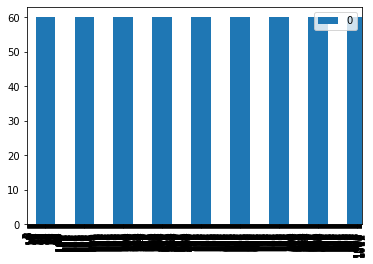

In [16]:
#After SMOTE
print(train_features_norm_sm.shape)
print(train_labels_sm.shape)

count = Counter(train_labels_sm)
df = pd.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

In [ ]:
pca = PCA(n_components=500)
train_features_red_sm = pca.fit_transform(train_features_norm_sm)
validation_features_red = pca.transform(validation_features_norm)
clf = LogisticRegression(C= 100, class_weight = 'balanced', random_state=0).fit(train_features_red_sm, train_labels_sm)
predictions = np.array(clf.predict(validation_features_red))
#calculate mean class accuracy
acc = accuracy_score(validation_labels, predictions)
print("Cost parameter: ", 100)
print("Mean class accuracy: ", acc)